In [1]:
### utils

import numpy as np
from gdshelpers.geometry.chip import Cell
from gdshelpers.parts.text import Text
from gdshelpers.parts.marker import DLWMarker, SquareMarker, CrossMarker
from gdshelpers.parts.waveguide import Waveguide
from gdshelpers.parts.port import Port
from gdshelpers.geometry.shapely_adapter import geometric_union
from gdshelpers.parts.coupler import GratingCoupler
from gdshelpers.parts.spiral import Spiral
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import Polygon

def update_bounds(bounds1, bounds2):
    # (minx, miny, maxx, maxy)
    return (min(bounds1[0], bounds2[0]),
            min(bounds1[1], bounds2[1]),
            max(bounds1[2], bounds2[2]),
            max(bounds1[3], bounds2[3]))


def fix_dict(parameters, kwargs):
    if 'kwarg_verbose' in kwargs:
        parameters['kwarg_verbose'] = kwargs['kwarg_verbose']
    else:
        parameters['kwarg_verbose'] = False
    for key, value in kwargs.items():
        if key in parameters:
            parameters[key] = value
        else:
            if parameters['kwarg_verbose']:
                print(key, 'is not a parameter for this function')
    
    
def single_wf_from_bounds(cell, wf_bounds, wf_layer):
    wf_corners = [(  # top_left corner (minx, maxy)
                          wf_bounds[0],
                          wf_bounds[3]
                      ),
                      (  # top_right corner (maxx, maxy)
                          wf_bounds[2],
                          wf_bounds[3]
                      ),
                      (  # bottom_right corner (maxx, miny)
                          wf_bounds[2],
                          wf_bounds[1]
                      ),
                      (  # bottom_left_corner (minx, miny)
                          wf_bounds[0],
                          wf_bounds[1]
                      )]
    wf_polygon = Polygon(wf_corners)
    cell.add_to_layer(wf_layer, wf_polygon)


def wf_line_from_bounds(cell,
                        bounds,
                        wf_maxlength,
                        wf_layer,
                        wf_additions = {},
                        axis=1,
                        direction=1):
    # assumes x direction is fine and that leeways have been included in the bounds
    dir_idx = 1
    if direction == -1:
        dir_idx = 0
    current_position = bounds[axis+2*(1-dir_idx)]
    if direction == 1:
        current_limit = min(current_position + wf_maxlength, bounds[axis+2])
    else:
        current_limit = max(current_position - wf_maxlength, bounds[axis])
    wf_bounds = list(bounds).copy()
    iteration = 0
    while current_limit != bounds[axis+2*dir_idx]:
        wf_bounds[axis+2*(1-dir_idx)] = current_position
        wf_bounds[axis+2*dir_idx] = current_limit
        wf_addition = (0, 0, 0, 0)
        if iteration in wf_additions.keys():
            wf_addition = wf_additions[iteration]
            bounds = np.add(bounds, wf_addition)
        single_wf_from_bounds(cell, np.add(wf_bounds, wf_addition), wf_layer)
        current_position=current_limit
        if direction == 1:
            current_limit = min(current_position + wf_maxlength, bounds[axis+2])
        else:
            current_limit = max(current_position - wf_maxlength, bounds[axis])
        iteration+=1
    wf_addition = (0, 0, 0, 0)
    if -1 in wf_additions.keys():
        wf_addition = wf_additions[-1]
        bounds = np.add(bounds, wf_addition)    
    wf_bounds[axis+2*(1-dir_idx)] = current_position
    wf_bounds[axis+2*dir_idx] = current_limit
    single_wf_from_bounds(cell, np.add(wf_bounds, wf_addition), wf_layer)
    return bounds


In [57]:
### parts

std_coupler_params = {
    'width': 0.5,
    'full_opening_angle': np.deg2rad(90),
    'grating_period': 0.46,
    'grating_ff': 0.3,
    'n_gratings': 10,
    'ap_max_ff': 0.8,
    'n_ap_gratings': 55,
    'taper_length': 12
}


def add_markers_to_top(cell,
                       wf_bounds,
                       device_top_bound,
                       marker_dims,
                       marker_layer_1,
                       marker_layer_2,
                       marker_protection_layer):
    marker_positions_1 = [(wf_bounds[0] + 3*marker_dims,
                           wf_bounds[3] - 3*marker_dims),
                          (wf_bounds[2] - 3*marker_dims,
                           wf_bounds[3] - 3*marker_dims),
                          (wf_bounds[2] - 3*marker_dims,
                           device_top_bound + 80
                           + 3*marker_dims)]
    marker_positions_2 = [(marker_positions_1[0][0] + marker_dims*3,
                           marker_positions_1[0][1]),
                          (marker_positions_1[1][0] - marker_dims*3,
                           marker_positions_1[1][1]),
                          (marker_positions_1[2][0] - marker_dims*3,
                           marker_positions_1[2][1])]
    markers_1 = [SquareMarker.make_marker(position, marker_dims)
                 for position in marker_positions_1]
    markers_1_protection = [SquareMarker.make_marker(position, 2*marker_dims)
                            for position in marker_positions_1]
    markers_2 = [SquareMarker.make_marker(position, marker_dims)
                 for position in marker_positions_2]
    markers_2_protection = [SquareMarker.make_marker(position, 2*marker_dims)
                            for position in marker_positions_2]
    for idx in range(len(markers_1)):
        cell.add_to_layer(marker_layer_1, markers_1[idx])
        cell.add_to_layer(marker_protection_layer,
                          markers_1_protection[idx])
        cell.add_to_layer(marker_layer_2, markers_2[idx])
        cell.add_to_layer(marker_protection_layer,
                          markers_2_protection[idx])


def add_markers_to_bottom_of_cell(cell,
                                  wf_bounds,
                                  device_bottom_bound,
                                  marker_dims,
                                  marker_layer_1,
                                  marker_layer_2,
                                  marker_protection_layer):
    marker_positions_1 = [(wf_bounds[0] +
                           3*marker_dims,
                           wf_bounds[1] + 3*marker_dims),
                          (wf_bounds[2] -
                           3*marker_dims,
                           wf_bounds[1] + 3*marker_dims),
                          (wf_bounds[2] -
                           3*marker_dims,
                           device_bottom_bound - 80
                           - 3*marker_dims)]
    marker_positions_2 = [(marker_positions_1[0][0] + marker_dims*3,
                           marker_positions_1[0][1]),
                          (marker_positions_1[1][0] - marker_dims*3,
                           marker_positions_1[1][1]),
                          (marker_positions_1[2][0] - marker_dims*3,
                           marker_positions_1[2][1])]
    markers_1 = [SquareMarker.make_marker(position, marker_dims)
                 for position in marker_positions_1]
    markers_1_protection = [SquareMarker.make_marker(position, 2*marker_dims)
                            for position in marker_positions_1]
    markers_2 = [SquareMarker.make_marker(position, marker_dims)
                 for position in marker_positions_2]
    markers_2_protection = [SquareMarker.make_marker(position, 2*marker_dims)
                            for position in marker_positions_2]
    for idx in range(len(markers_1)):
        cell.add_to_layer(marker_layer_1, markers_1[idx])
        cell.add_to_layer(marker_protection_layer,
                          markers_1_protection[idx])
        cell.add_to_layer(marker_layer_2, markers_2[idx])
        cell.add_to_layer(marker_protection_layer,
                          markers_2_protection[idx])


def wgs_to_fiber_array(
    cell,
    ports,
    coupler_positions,
    min_radius,
    gc_leeway,
    wg_sep,
    wg_layer,
    wf_layer,
    is_incoupling
):
    total_bounds = (np.inf, np.inf, -np.inf, -np.inf)
    wgs = [Waveguide.make_at_port(prt) for prt in ports]
    first_bend = np.pi/2
    wg_distances = [0 for _ in range(len(wgs))]
    if is_incoupling:
        first_bend = -np.pi/2
        coupler_positions = coupler_positions[::-1]
    if not is_incoupling:
        wgs = wgs[::-1]
#         edge_position = coupler_positions[0][0]
    for idx, wg in enumerate(wgs):
        # this calculated distance is wrong by about 0.02,
        # which I think is okay
        distance = (2 * min_radius*np.pi  # x
                    + abs(coupler_positions[-1][0]
                          - wgs[idx].current_port.origin[0])
                    + abs(coupler_positions[-1][0]
                          - coupler_positions[idx][0])
                    - 2*min_radius
                    + 2*gc_leeway
                    + 2*(3-idx) * wg_sep
                    + abs(wgs[idx].current_port.origin[1]  # y
                          - coupler_positions[0][1])
                    - 4*min_radius
                    + 2*(3-idx)*wg_sep)
        wg_distances[idx] = distance
    max_distance = max(wg_distances)
    for idx, wg in enumerate(wgs):
        if is_incoupling:
            wg._current_port.angle = -np.pi/2
        wg.add_straight_segment(wg_sep*idx)
        # first bend then heading away from structure
        wg.add_bend(first_bend, min_radius)
        wg.add_straight_segment_until_x(coupler_positions[-1][0]
                                        + np.sin(first_bend) *
                                        (gc_leeway
                                         + (3-idx)*wg_sep
                                         - min_radius)
                                        )
        # second bend then heading downwards
        wg.add_bend(-first_bend, min_radius)
        wg.add_straight_segment_until_y(coupler_positions[0][1]
                                        - (3-idx)*wg_sep)
        # third bend then heading towards gcs
        wg.add_bend(-first_bend, min_radius)
        wg.add_straight_segment_until_x(coupler_positions[idx][0]
                                        + np.sin(first_bend) * min_radius)
        # ADD WIGGLES HERE the extra distance added should be equal to
        # extra distance
        extra_distance = max_distance - wg_distances[idx]
        wg.add_bend(-first_bend, min_radius)
        wg.add_straight_segment_until_y(coupler_positions[0][1])
        total_bounds = update_bounds(total_bounds,
                                     wg.get_shapely_outline().bounds)
        cell.add_to_layer(wg_layer, wg)
        grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
            wg.current_port, **std_coupler_params
        )
        cell.add_to_layer(wg_layer, grating_coupler)
    return total_bounds


def expand_wgs_section_1(wgs, parameters):
    # assume the first (final) inport is always the leftmost (rightmost)
    global_x_middle = (wgs[0].current_port.origin[0]
                       + wgs[-1].current_port.origin[0])/2
    desired_x_position = np.zeros(len(wgs))
    desired_x_position[:2] = np.array([global_x_middle
                                       - (parameters['electrode_wg_sep'])/2
                                       - j * parameters['wg_sep']
                                       for j in range(1, -1, -1)])
    desired_x_position[2:] = np.array([global_x_middle
                                       + (parameters['electrode_wg_sep'])/2
                                       + j * parameters['wg_sep']
                                       for j in range(2)])
    # get the wgs to where we want them to be
    for idx, wg in enumerate(wgs):
        if wg.current_port.angle == np.pi/2:
            s_y_length = desired_x_position[idx] - wg.current_port.origin[0]
        else:
            s_y_length = wg.current_port.origin[0] - desired_x_position[idx]
        s_x_length = parameters['sine_s_x']
        wg.add_parameterized_path(path=lambda t: (t * s_x_length,
                                                  .5 * (np.cos(np.pi * t) - 1)
                                                  * s_y_length),
                                  path_derivative=lambda t: (
                                      s_x_length, -np.pi * .5
                                      * np.sin(np.pi * t) * s_y_length
                                  ))
    return global_x_middle, desired_x_position


def expand_wgs_section_2(wgs, parameters):
    # assume the first (final) inport is always the leftmost (rightmost)
    global_x_middle = (wgs[0].current_port.origin[0]
                       + wgs[-1].current_port.origin[0])/2
    desired_x_position = [global_x_middle + (idx - 1.5) * parameters['wg_sep']
                          for idx in range(len(wgs))]
    desired_x_position[0] = (desired_x_position[1]
                             - parameters['electrode_wg_sep'])
    desired_x_position[3] = (desired_x_position[2]
                             + parameters['electrode_wg_sep'])
    # get the wgs to where we want them to be
    for idx, wg in enumerate(wgs):
        if wg.current_port.angle == np.pi/2:
            s_y_length = desired_x_position[idx] - wg.current_port.origin[0]
        else:
            s_y_length = wg.current_port.origin[0] - desired_x_position[idx]
        s_x_length = parameters['sine_s_x']
        wg.add_parameterized_path(path=lambda t: (t * s_x_length, .5
                                                  * (np.cos(np.pi * t) - 1)
                                                  * s_y_length),
                                  path_derivative=lambda t: (
                                      s_x_length, -np.pi * .5
                                      * np.sin(np.pi * t) * s_y_length
                                  ))
    return global_x_middle, desired_x_position


def deexpand_wgs(wgs, global_x_middle, parameters):
    desired_x_position = [global_x_middle + (idx - 1.5) * parameters['wg_sep']
                          for idx in range(len(wgs))]
    for idx, wg in enumerate(wgs):
        if wg.current_port.angle == np.pi/2:
            s_y_length = desired_x_position[idx] - wg.current_port.origin[0]
        else:
            s_y_length = wg.current_port.origin[0] - desired_x_position[idx]
        s_x_length = parameters['sine_s_x']
        wg.add_parameterized_path(path=lambda t: (t * s_x_length, .5
                                                  * (np.cos(np.pi * t) - 1)
                                                  * s_y_length),
                                  path_derivative=lambda t: (
                                      s_x_length, -np.pi * .5
                                      * np.sin(np.pi * t) * s_y_length
                                  ))
    return


def build_kinks(cell,
                left_wg,
                signal_wg,
                right_wg,
                kink,
                electrode_layer,
                electrode_wf_layer,
                previous_line_bounds,
                left_side,
                parameters):
    # INPUT THE KINKY CODE HERE
    initial_angle = left_wg.current_port.angle
    # left_wg
    if left_side:
        kink_1_line_bounds = [np.inf,
                              np.inf,
                              previous_line_bounds[0],
                              -np.inf]
        wf_direction = -1
    else:
        kink_1_line_bounds = [previous_line_bounds[2],
                              np.inf,
                              -np.inf,
                              -np.inf]
        wf_direction = 1
    left_wg.add_straight_segment_until_x(kink[0]
                                         - parameters['electrode_pitch'])
    if left_side:
        kink_1_line_bounds[0] = (left_wg.current_port.origin[0]
                                 - parameters['wf_leeways'][0]/2)
        kink_1_line_bounds[1] = (left_wg.current_port.origin[1]
                                 - left_wg.current_port.width/2)
    else:
        kink_1_line_bounds[3] = (left_wg.current_port.origin[1]
                                 + left_wg.current_port.width/2)
    # 90 degree turn
    left_wg._current_port.origin[0] = (left_wg.current_port.origin[0]
                                       - np.cos(left_wg.current_port.angle)
                                       * left_wg.current_port.width/2.0)
    left_wg._current_port.angle = np.pi/2
    # straight segment to the next turn
    left_wg.add_straight_segment_until_y(kink[1]
                                         + np.cos(initial_angle)
                                         * parameters['electrode_pitch'])
    # 90 degree turn
    left_wg._current_port.angle = initial_angle
    left_wg._current_port.origin[0] = (left_wg._current_port.origin[0]
                                       - np.cos(initial_angle)
                                       * left_wg.current_port.width/2)

    # signal_wg
    signal_wg.add_straight_segment_until_x(kink[0])
    # 90 degree turn
    signal_wg._current_port.origin[0] = (signal_wg.current_port.origin[0]
                                         - np.cos(signal_wg.current_port.angle)
                                         * signal_wg.current_port.width/2.0)
    signal_wg._current_port.angle = np.pi/2
    # straight segment to the next turn
    signal_wg.add_straight_segment_until_y(kink[1])
    # 90 degree turn
    signal_wg._current_port.angle = initial_angle
    signal_wg._current_port.origin[0] = (signal_wg._current_port.origin[0]
                                         - np.cos(initial_angle)
                                         * signal_wg.current_port.width/2)

    # right_wg
    right_wg.add_straight_segment_until_x(kink[0]
                                          + parameters['electrode_pitch'])
    if not left_side:
        kink_1_line_bounds[2] = (right_wg.current_port.origin[0]
                                 + parameters['wf_leeways'][0]/2)
        kink_1_line_bounds[1] = (right_wg.current_port.origin[1]
                                 - right_wg.current_port.width/2)
    else:
        kink_1_line_bounds[3] = (right_wg.current_port.origin[1]
                                 + right_wg.current_port.width/2)
    # 90 degree turn
    right_wg._current_port.origin[0] = (right_wg.current_port.origin[0]
                                        - np.cos(right_wg.current_port.angle)
                                        * right_wg.current_port.width/2.0)
    right_wg._current_port.angle = np.pi/2
    # straight segment to the next turn
    right_wg.add_straight_segment_until_y(kink[1]
                                          - np.cos(initial_angle)
                                          * parameters['electrode_pitch'])
    # 90 degree turn
    right_wg._current_port.angle = initial_angle
    right_wg._current_port.origin[0] = (right_wg._current_port.origin[0]
                                        - np.cos(initial_angle)
                                        * right_wg.current_port.width/2)
    _ = wf_line_from_bounds(
        cell=cell,
        bounds=kink_1_line_bounds,
        wf_maxlength=parameters['wf_maxlength'],
        wf_layer=electrode_wf_layer,
        axis=0,
        direction=wf_direction
    )
    if left_side:
        kink_2_line_bounds = [
            kink_1_line_bounds[0],
            kink_1_line_bounds[3],
            (right_wg.current_port.origin[0]
             + parameters['wf_leeways'][0]/2),
            (left_wg.current_port.origin[1]
             - left_wg.current_port.width/2
             - parameters['wf_leeways'][1]/2)
        ]
        _ = wf_line_from_bounds(
            cell=cell,
            bounds=kink_2_line_bounds,
            wf_maxlength=parameters['wf_maxlength'],
            wf_layer=electrode_wf_layer
        )
        kink_2_line_bounds[0] = kink_2_line_bounds[2]
        # Tells where the next electrodes should branch in order
        # to run alongside this one
        next_kink = [kink[0] - 3 * parameters['electrode_pitch'],
                     left_wg.current_port.origin[1]
                     - 2 * parameters['electrode_pitch']]
    else:
        kink_2_line_bounds = [
            left_wg.current_port.origin[0] - parameters['wf_leeways'][0]/2,
            kink_1_line_bounds[3],
            (right_wg.current_port.origin[0]
             + right_wg.current_port.width
             + parameters['wf_leeways'][0]/2),
            (right_wg.current_port.origin[1]
             - right_wg.current_port.width/2
             - parameters['wf_leeways'][1]/2)
        ]
        _ = wf_line_from_bounds(
            cell=cell,
            bounds=kink_2_line_bounds,
            wf_maxlength=parameters['wf_maxlength'],
            wf_layer=electrode_wf_layer
        )
        kink_2_line_bounds[2] = kink_2_line_bounds[0]
        # Tells where the next electrodes should branch in order
        # to run alongside this one
        next_kink = [kink[0] + 3 * parameters['electrode_pitch'],
                     right_wg.current_port.origin[1]
                     - 2 * parameters['electrode_pitch']]
    return kink_2_line_bounds, next_kink


def electrode_connector(cell,
                        left_wg,
                        signal_wg,
                        right_wg,
                        kink,
                        electrode_layer,
                        electrode_wf_layer,
                        connector_coordinates,
                        previous_line_bounds,
                        left_side,
                        parameters):
    # Collect electrodes to save space
    if kink != [-1, -1]:
        previous_line_bounds, next_kink = build_kinks(
            cell,
            left_wg,
            signal_wg,
            right_wg,
            kink,
            electrode_layer,
            electrode_wf_layer,
            previous_line_bounds,
            left_side,
            parameters
        )

    if left_side:
        first_line_bounds = [-1,
                             (left_wg.current_port.origin[1]
                              - left_wg.current_port.width/2
                              - parameters['wf_leeways'][1]/2),
                             previous_line_bounds[0],
                             (right_wg.current_port.origin[1]
                              + right_wg.current_port.width/2
                              + parameters['wf_leeways'][1]/2)]
        wf_direction = -1
    else:
        first_line_bounds = [previous_line_bounds[2],
                             (right_wg.current_port.origin[1]
                              - right_wg.current_port.width/2
                              - parameters['wf_leeways'][1]/2),
                             -1,
                             (left_wg.current_port.origin[1]
                              + left_wg.current_port.width/2
                              + parameters['wf_leeways'][1]/2)]
        wf_direction = 1

    # left_wg
    left_wg_goal_x = (connector_coordinates[0]
                      - parameters['connector_probe_pitch'])
    left_wg.add_straight_segment_until_x(left_wg_goal_x)
    if not left_side:
        first_line_bounds[2] = (left_wg.current_port.origin[0]
                                - left_wg.current_port.width/2
                                - parameters['connector_probe_dims'][0]/2
                                - parameters['wf_leeways'][0]/2)
        _ = wf_line_from_bounds(
                cell=cell,
                bounds=first_line_bounds,
                wf_maxlength=parameters['wf_maxlength'],
                wf_layer=electrode_wf_layer,
                axis=0,
                direction=wf_direction
            )
    # 90 degree turn
    left_wg._current_port.origin[0] = (left_wg.current_port.origin[0]
                                       - np.cos(left_wg.current_port.angle)
                                       * left_wg.current_port.width/2.0)
    left_wg._current_port.angle = np.pi/2
    left_wg._current_port.origin[1] = (left_wg._current_port.origin[1]
                                       + left_wg.current_port.width/2.0)

    # signal_wg (which is also the center wg)
    signal_wg_goal_x = connector_coordinates[0]
    signal_wg.add_straight_segment_until_x(signal_wg_goal_x)
    # 90 degree turn
    signal_wg._current_port.origin[0] = (signal_wg.current_port.origin[0]
                                         - np.cos(signal_wg.current_port.angle)
                                         * signal_wg.current_port.width/2.0)
    signal_wg._current_port.angle = np.pi/2
    signal_wg._current_port.origin[1] = (signal_wg._current_port.origin[1]
                                         + signal_wg.current_port.width/2.0)

    # right_wg
    right_wg_goal_x = (connector_coordinates[0]
                       + parameters['connector_probe_pitch'])
    right_wg.add_straight_segment_until_x(right_wg_goal_x)
    if left_side:
        first_line_bounds[0] = (right_wg.current_port.origin[0]
                                + right_wg.current_port.width/2
                                + parameters['connector_probe_dims'][0]/2
                                + parameters['wf_leeways'][0]/2)
        _ = wf_line_from_bounds(
                cell=cell,
                bounds=first_line_bounds,
                wf_maxlength=parameters['wf_maxlength'],
                wf_layer=electrode_wf_layer,
                axis=0,
                direction=wf_direction
            )
    # 90 degree turn
    right_wg._current_port.origin[0] = (right_wg.current_port.origin[0]
                                        - np.cos(right_wg.current_port.angle)
                                        * right_wg.current_port.width/2.0)
    right_wg._current_port.angle = np.pi/2

    # Tells where the next electrodes should branch in order
    # to run alongside this one
    if kink == [-1, -1]:
        if left_side:
            next_kink = [right_wg_goal_x - parameters['electrode_pitch'],
                         left_wg.current_port.origin[1]
                         - 2 * parameters['electrode_pitch']
                         - left_wg.current_port.width/2.0]
        else:
            next_kink = [left_wg_goal_x + parameters['electrode_pitch'],
                         right_wg.current_port.origin[1]
                         - 2 * parameters['electrode_pitch']]

    # get the wgs to the start of the probe connector
    left_wg.add_straight_segment_until_y(
        connector_coordinates[1],
        final_width=parameters['connector_probe_dims'][0]
    )
    signal_wg.add_straight_segment_until_y(
        connector_coordinates[1],
        final_width=parameters['connector_probe_dims'][0]
    )
    right_wg.add_straight_segment_until_y(
        connector_coordinates[1],
        final_width=parameters['connector_probe_dims'][0]
    )
    # probe connector
    left_wg.add_straight_segment(
        parameters['connector_probe_dims'][1]
    )
    signal_wg.add_straight_segment(
        parameters['connector_probe_dims'][1]
    )
    right_wg.add_straight_segment(
        parameters['connector_probe_dims'][1]
    )
    if left_side:
        second_line_bounds = [(left_wg.current_port.origin[0]
                               - left_wg.current_port.width/2
                               - parameters['wf_leeways'][0]/2),
                              first_line_bounds[1],
                              first_line_bounds[0],
                              (left_wg.current_port.origin[1]
                               - parameters['electrode_width']
                               - parameters['wf_leeways'][1]/2)]
    else:
        second_line_bounds = [first_line_bounds[2],
                              first_line_bounds[1],
                              (right_wg.current_port.origin[0]
                               + right_wg.current_port.width/2
                               + parameters['wf_leeways'][0]/2),
                              (left_wg.current_port.origin[1]
                               - parameters['electrode_width']
                               - parameters['wf_leeways'][1]/2)]

    _ = wf_line_from_bounds(
                cell=cell,
                bounds=second_line_bounds,
                wf_maxlength=parameters['wf_maxlength'],
                wf_layer=electrode_wf_layer
            )
    final_wf_bounds = [-1,
                       second_line_bounds[3],
                       -1,
                       second_line_bounds[3] + parameters['wf_maxlength']]

    # electrode_connector
    # make sure the contact pad does not touch the ground electrodes
    signal_wg.add_straight_segment(parameters['electrode_pad_seps'][1])
    contact_pad_y = signal_wg.current_port.origin[1]
    signal_wg._current_port.width = parameters['contact_pad_dims'][0]
    signal_wg.add_straight_segment(parameters['contact_pad_dims'][1])
    # left_wg should go to the the ground contact pad
    # clear away from the signal contact pad
    left_wg._current_port.width = parameters['electrode_width']
    left_wg._current_port.angle = np.pi
    left_wg._current_port.origin[1] = (left_wg.current_port.origin[1]
                                       - left_wg.current_port.width/2)
    left_wg.add_straight_segment_until_x(signal_wg.current_port.origin[0]
                                         - parameters['contact_pad_dims'][0]
                                         - parameters['contact_pad_sep'])
    # get the start of the contact pad to the same position as the signal
    # pad
    left_wg._current_port.angle = np.pi/2
    left_wg._current_port.origin[1] = (left_wg.current_port.origin[1]
                                       - left_wg.current_port.width/2)
    left_wg.add_straight_segment_until_y(contact_pad_y)
    # ground contact pad
    left_wg._current_port.width = parameters['contact_pad_dims'][0]
    left_wg.add_straight_segment(parameters['contact_pad_dims'][1])
    final_wf_bounds[0] = (left_wg.current_port.origin[0]
                          - left_wg.current_port.width/2
                          - parameters['wf_leeways'][0])
    # route the right wg to the ground pad
    # clear away from the signal contact pad
    right_wg._current_port.width = parameters['electrode_width']

    x_goal_length = (signal_wg.current_port.origin[0]
                     + parameters['contact_pad_dims'][0]/2
                     + parameters['electrode_pad_seps'][0]
                     - right_wg.current_port.origin[0])
    if x_goal_length > parameters['connector_probe_dims'][0]/2:
        right_wg._current_port.angle = 0
        right_wg._current_port.origin[1] = (right_wg.current_port.origin[1]
                                            - right_wg.current_port.width/2)
        right_wg.add_straighw_segment(x_goal_length)
#         right_wg.add_straight_segment_until_x(signal_wg.current_port.origin[0]
#                                               + x_goal_length)
        right_wg._current_port.angle = np.pi/2
        right_wg._current_port.origin[1] = (right_wg.current_port.origin[1]
                                            - right_wg.current_port.width/2)
    else:
        right_wg._current_port.origin[0] = (
            right_wg.current_port.origin[0]
            + parameters['connector_probe_dims'][0]/2
            - right_wg.current_port.width/2
        )

    right_wg.add_straight_segment_until_y(left_wg.current_port.origin[1]
                                          + parameters['electrode_pad_seps'][0]
                                          + right_wg.current_port.width/2)
    final_wf_bounds[2] = (right_wg.current_port.origin[0]
                          + right_wg.current_port.width/2
                          + parameters['wf_leeways'][0])

    right_wg._current_port.angle = np.pi
    right_wg._current_port.origin[0] = (right_wg.current_port.origin[0]
                                        + right_wg.current_port.width/2)
    right_wg.add_straight_segment_until_x(left_wg.current_port.origin[0])
    right_wg._current_port.angle = -np.pi/2
    right_wg._current_port.origin[1] = (right_wg.current_port.origin[1]
                                        + right_wg.current_port.width/2)
    right_wg.add_straight_segment_until_y(left_wg.current_port.origin[1])
    _ = wf_line_from_bounds(
                cell=cell,
                bounds=final_wf_bounds,
                wf_maxlength=parameters['wf_maxlength'],
                wf_layer=electrode_wf_layer
            )
    # add markers
    top_bound = right_wg.get_shapely_outline().bounds[3]
    add_markers_to_top(cell=cell,
                       wf_bounds=final_wf_bounds,
                       device_top_bound=top_bound,
                       marker_dims=parameters['marker_dims'],
                       marker_layer_1=parameters['mk_layer_1'],
                       marker_layer_2=parameters['mk_layer_2'],
                       marker_protection_layer=parameters['mk_layer_3'])
    return next_kink


def phase_shifter_and_dc_wg(
    wgs,
    electrode_length,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    stagger_separation=0,
    **kwargs
):
    parameters = {
        'mm_wg_width': sm_wg_width,
        'mm_taper_length': 0,
        'min_radius': 50,
        'mzi_sep_leeway': 50,
        'wg_sep': 25,
        'electrode_wg_sep': 100,
        # For directional couplers and bends
        'sine_s_x': 60,
        # For writefields
        'wf_maxlength': 1040,
        'wf_leeways': (10, 0),
        'wf_x_sep': 10,
        'wf_electrode_leeways': (10, 10),
    }
    fix_dict(parameters, kwargs)
    for idx, wg in enumerate(wgs):
        # straight segment for the electrode
        wg.add_straight_segment(electrode_length+stagger_separation)

        # taper for mm assuming the wg is mm during electrodes
        if parameters['mm_taper_length'] > 0:
            wg.add_straight_segment(parameters['mm_taper_length'], sm_wg_width)

        # directional coupler
        x_length = parameters['sine_s_x']
        y_length = (parameters['wg_sep'] / 2.0
                    - (coupler_sep + sm_wg_width) / 2.0
                    - idx * (parameters['wg_sep'] - sm_wg_width - coupler_sep))
        if wg.current_port.angle == -np.pi/2:
            y_length *= -1
        wg.add_parameterized_path(path=lambda t: (t * x_length, .5
                                                  * (np.cos(np.pi * t) - 1)
                                                  * y_length),
                                  path_derivative=lambda t: (
                                         x_length, -np.pi * .5
                                         * np.sin(np.pi * t) * y_length
                                  ))
        wg.add_straight_segment(coupler_length)
        y_length = -(parameters['wg_sep'] / 2.0
                     - (coupler_sep + sm_wg_width) / 2.0
                     - idx * (parameters['wg_sep']
                     - sm_wg_width
                     - coupler_sep))
        if wg.current_port.angle == -np.pi/2:
            y_length *= -1
        wg.add_parameterized_path(path=lambda t: (t * x_length, .5
                                                  * (np.cos(np.pi * t) - 1)
                                                  * y_length),
                                  path_derivative=lambda t: (
                                      x_length, -np.pi * .5
                                      * np.sin(np.pi * t) * y_length
                                  ))
        if parameters['mm_taper_length'] > 0:
            wg.add_straight_segment(parameters['mm_taper_length'],
                                    parameters['mm_wg_width'])


def phase_shifter_electrodes(
    cell,
    reference_port,
    electrode_length,
    crossing_goal_position,
    direction,
    electrode_sep,
    electrode_layer,
    electrode_wf_layer,
    connector_coordinates,
    **kwargs
):
    parameters = {
        'wg_sep': 25,
        'mm_taper_length': 0,
        'sine_s_x': 60,
        'wf_maxlength': 1040,
        'wf_leeways': (10, 10),
        # For electrode function
        'electrode_width': 25,
        'electrode_sep': 1.1,
        'crossing_width': 10,
        'electrode_taper_leeway': 5,
        'electrode_taper_length': 30,
        'electrode_sep_y': 15,
        'electrode_pitch': 40,
        'connector_start_y': 7200,
        'connector_probe_dims': (80, 600),
        'connector_probe_pitch': 150,
        'contact_pad_dims': (250, 600),
        'contact_pad_sep': 150,
        'electrode_pad_seps': (30, 30),
        'pad_sep': 300,
    }
    fix_dict(parameters, kwargs)

    bounds = (np.inf, np.inf, -np.inf, -np.inf)
    wf_line_bounds = (np.inf, np.inf, -np.inf, -np.inf)

    if reference_port.angle == np.pi/2:
        crossing_angle = np.pi
        if direction == -1:
            reference_port.origin[1] = (reference_port.origin[1]
                                        + electrode_length)
    elif reference_port.angle == -np.pi/2:
        crossing_angle = 0
        if direction == 1:
            reference_port.origin[1] = (reference_port.origin[1]
                                        - electrode_length)

    left_inport = Port(
        (
            reference_port.origin[0]
            - (electrode_sep / 2.0 + parameters['electrode_width'] / 2),
            reference_port.origin[1]
        ),
        direction*np.pi/2.0, parameters['electrode_width']
    )

    signal_electrode_width = min(parameters['electrode_width'],
                                 parameters['wg_sep'] - electrode_sep)
    signal_inport = Port((reference_port.origin[0] + parameters['wg_sep']/2.0,
                          reference_port.origin[1]),
                         direction*np.pi/2.0, signal_electrode_width)
    right_inport = Port(
        (
            reference_port.origin[0]
            + parameters['wg_sep'] + electrode_sep / 2.0
            + parameters['electrode_width'] / 2.0,
            reference_port.origin[1]
        ),
        direction*np.pi/2.0, parameters['electrode_width']
    )

    signal_wg = Waveguide.make_at_port(signal_inport)

    if crossing_angle == 0:
        long_wg = Waveguide.make_at_port(left_inport)
        short_wg = Waveguide.make_at_port(right_inport)
    else:
        long_wg = Waveguide.make_at_port(right_inport)
        short_wg = Waveguide.make_at_port(left_inport)

    # short waveguide
    # the shorter waveguide must be shorter
    # to accomodate for the other two waveguides
    short_wg.add_straight_segment(electrode_length
                                  - 2 * parameters['electrode_sep_y']
                                  - 2 * parameters['electrode_width'])
    # 90 degree turn
    short_wg._current_port.angle = crossing_angle
    short_wg._current_port.origin[0] = (short_wg.current_port.origin[0]
                                        - np.cos(crossing_angle)
                                        * short_wg.current_port.width / 2.0)
    short_wg._current_port.width = parameters['crossing_width']
    short_wg._current_port.origin[1] = (short_wg.current_port.origin[1]
                                        - direction
                                        * short_wg.current_port.width/2.0)
    wf_line_bounds = update_bounds(wf_line_bounds,
                                   short_wg.get_shapely_outline().bounds)
    short_wg.add_straight_segment(abs(crossing_goal_position
                                      - short_wg.current_port.origin[0]))
    short_wg.add_straight_segment(parameters['electrode_taper_length'],
                                  parameters['electrode_width'])
    bounds = update_bounds(bounds, short_wg.get_shapely_outline().bounds)

    # signal waveguide (always in the middle)
    # the signal waveguide must also be slightly shorter
    # to accomodate for the longest waveguide
    signal_wg.add_straight_segment(electrode_length
                                   - parameters['electrode_sep_y']
                                   - parameters['electrode_width'])
    # 90 degree turn
    signal_wg._current_port.angle = crossing_angle
    signal_wg._current_port.origin[0] = (signal_wg.current_port.origin[0]
                                         - np.cos(crossing_angle)
                                         * signal_wg.current_port.width/2.0)
    signal_wg._current_port.width = parameters['crossing_width']
    signal_wg._current_port.origin[1] = (signal_wg.current_port.origin[1]
                                         - direction
                                         * signal_wg.current_port.width/2.0)
    wf_line_bounds = update_bounds(wf_line_bounds,
                                   signal_wg.get_shapely_outline().bounds)
    # crossing segment + taper
    signal_wg.add_straight_segment(abs(crossing_goal_position
                                       - signal_wg.current_port.origin[0]))
    signal_wg.add_straight_segment(parameters['electrode_taper_length'],
                                   parameters['electrode_width'])
    bounds = update_bounds(bounds, signal_wg.get_shapely_outline().bounds)

    # long waveguide
    long_wg.add_straight_segment(electrode_length)
    # 90 degree turn
    long_wg._current_port.angle = crossing_angle
    long_wg._current_port.origin[0] = (long_wg.current_port.origin[0]
                                       - np.cos(crossing_angle)
                                       * long_wg.current_port.width/2.0)
    long_wg._current_port.width = parameters['crossing_width']
    long_wg._current_port.origin[1] = (long_wg.current_port.origin[1]
                                       - direction
                                       * long_wg.current_port.width/2.0)
    wf_line_bounds = update_bounds(wf_line_bounds,
                                   long_wg.get_shapely_outline().bounds)
    # crossing segment + taper
    long_wg.add_straight_segment(abs(crossing_goal_position
                                     - long_wg.current_port.origin[0]))
    long_wg.add_straight_segment(parameters['electrode_taper_length'],
                                 parameters['electrode_width'])
    bounds = update_bounds(bounds, long_wg.get_shapely_outline().bounds)
    # the extra width ensures no tapers are clipped
    extra_width = (parameters['electrode_width']/2
                   - parameters['crossing_width']/2)
    wf_line_bounds = (wf_line_bounds[0],
                      wf_line_bounds[1] - extra_width,
                      wf_line_bounds[2],
                      wf_line_bounds[3] + extra_width)
    _ = wf_line_from_bounds(
        cell=cell,
        bounds=wf_line_bounds,
        wf_maxlength=parameters['wf_maxlength'],
        wf_layer=electrode_wf_layer
    )

    cell.add_to_layer(electrode_layer, short_wg, signal_wg, long_wg)
    return (short_wg, signal_wg, long_wg, direction, wf_line_bounds)


def section_1_dcs_electrodes(
    cell,
    wgs,
    electrode_length,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    connector_coordinates,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    parameters
):
    # First two waveguides
    if wgs[0].current_port.angle == np.pi/2:
        direction_1 = -1
        direction_2 = 1
        crossing_goal_position = (wgs[0].current_port.origin[0]
                                  - wgs[0].current_port.width/2)
    else:
        direction_1 = 1
        direction_2 = -1
        crossing_goal_position = (wgs[-1].current_port.origin[0]
                                  + wgs[-1].current_port.width/2)

    stagger_separation = (2*(parameters['sine_s_x'] + coupler_length)
                          + 3*parameters['electrode_width']
                          + 2*parameters['electrode_sep_y'])/2

    electrodes_1 = phase_shifter_electrodes(
        cell=cell,
        reference_port=wgs[0].current_port,
        electrode_length=electrode_length,
        crossing_goal_position=crossing_goal_position,
        direction=direction_1,
        electrode_layer=electrode_layer,
        electrode_wf_layer=electrode_wf_layer,
        connector_coordinates=connector_coordinates[0],
        **parameters
    )
    phase_shifter_and_dc_wg(wgs[:2],
                            electrode_length=electrode_length,
                            coupler_sep=coupler_sep,
                            coupler_length=coupler_length,
                            sm_wg_width=sm_wg_width,
                            wg_layer=wg_layer,
                            wf_layer=wf_layer,
                            electrode_layer=electrode_layer,
                            electrode_wf_layer=electrode_wf_layer,
                            stagger_separation=stagger_separation,
                            **parameters)

    # Second two waveguides
    for wg in wgs[2:]:
        wg.add_straight_segment(stagger_separation)
    electrodes_2 = phase_shifter_electrodes(
        cell=cell,
        reference_port=wgs[2].current_port,
        electrode_length=electrode_length,
        crossing_goal_position=crossing_goal_position,
        direction=direction_2,
        electrode_layer=electrode_layer,
        electrode_wf_layer=electrode_wf_layer,
        connector_coordinates=connector_coordinates[1],
        **parameters)
    phase_shifter_and_dc_wg(wgs[2:],
                            electrode_length=electrode_length,
                            coupler_sep=coupler_sep,
                            coupler_length=coupler_length,
                            sm_wg_width=sm_wg_width,
                            wg_layer=wg_layer,
                            wf_layer=wf_layer,
                            electrode_layer=electrode_layer,
                            electrode_wf_layer=electrode_wf_layer,
                            stagger_separation=0,
                            **parameters)
    return [electrodes_1, electrodes_2]


def section_2_dcs_electrodes(
    cell,
    wgs,
    electrode_length,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    connector_coordinates,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    parameters,
    extra_wiggle_lengths=[-1, -1, -1, -1]
):
    # Interacting waveguides
    if wgs[1].current_port.angle == np.pi/2:
        direction_1 = 1
        crossing_goal_position = (wgs[0].current_port.origin[0]
                                  - wgs[0].current_port.width/2)
    else:
        direction_1 = -1
        crossing_goal_position = (wgs[-1].current_port.origin[0]
                                  + wgs[-1].current_port.width/2)
    electrodes = phase_shifter_electrodes(
        cell=cell,
        reference_port=wgs[1].current_port,
        electrode_length=electrode_length,
        crossing_goal_position=crossing_goal_position,
        direction=direction_1,
        electrode_layer=electrode_layer,
        electrode_wf_layer=electrode_wf_layer,
        connector_coordinates=connector_coordinates,
        **parameters)
    phase_shifter_and_dc_wg(wgs[1:3],
                            electrode_length=electrode_length,
                            coupler_sep=coupler_sep,
                            coupler_length=coupler_length,
                            sm_wg_width=sm_wg_width,
                            wg_layer=wg_layer,
                            wf_layer=wf_layer,
                            electrode_layer=electrode_layer,
                            electrode_wf_layer=electrode_wf_layer,
                            **parameters)

    # Delayed waveguides
    for idx in (0, 3):
        if extra_wiggle_lengths == [-1, -1, -1, -1]:
            path_length_difference = wgs[1].length - wgs[idx].length
        else:
            path_length_difference = extra_wiggle_lengths[idx]
        current_y_position = wgs[idx].current_port.origin[1]
        goal_y_position = wgs[1].current_port.origin[1]
        # ADD WIGGLES HERE: need the path length to be
        # equal to path_length_difference, and for the
        # waveguide to extend to goal_y_position
        wgs[idx].add_straight_segment(abs(goal_y_position-current_y_position))
    return electrodes


def build_curve(wgs,
                next_section,
                parameters,
                extra_wiggle_lengths,
                next_middle_point=-1):
    current_middle_point = (wgs[0].current_port.origin[0]
                            + wgs[-1].current_port.origin[0])/2
    # allow to set manually
    if next_middle_point == -1:
        next_middle_point = (current_middle_point
                             + 2*parameters['wg_sep']
                             + 2.5*parameters['electrode_wg_sep'])
    if next_section == 1:
        goal_x_positions = [  # leftmost to rightmost
                            (next_middle_point
                             + 0.5*parameters['electrode_wg_sep']
                             + parameters['wg_sep']),
                            # #2 from left to #2 from right
                            (next_middle_point
                             + 0.5*parameters['electrode_wg_sep']),
                            # #2 from right to #2 from left
                            (next_middle_point
                             - 0.5*parameters['electrode_wg_sep']),
                            # rightmost to leftmost
                            (next_middle_point
                             - 0.5*parameters['electrode_wg_sep']
                             - parameters['wg_sep'])
                           ]
    else:
        goal_x_positions = [  # leftmost to rightmost
                            (next_middle_point
                             + 0.5*parameters['wg_sep']
                             + parameters['electrode_wg_sep']),
                            # #2 from left to #2 from right
                            (next_middle_point
                             + 0.5*parameters['wg_sep']),
                            # #2 from right to #2 from left
                            (next_middle_point
                             - 0.5*parameters['wg_sep']),
                            # rightmost to leftmost
                            (next_middle_point
                             - 0.5*parameters['wg_sep']
                             - parameters['electrode_wg_sep'])
                           ]
    longest_path_length = -1
    for idx, wg in enumerate(wgs):
        # turn to the right
        if wg.current_port.angle == np.pi/2:
            wg.add_straight_segment((3-idx) * parameters['wg_sep'])
            wg.add_bend(-np.pi/2, parameters['min_radius'])
            if idx == 0 or idx == 3:
                wg.add_straight_segment((3-idx) * parameters['wg_sep'])
                wg.add_straight_segment_until_x(goal_x_positions[idx]
                                                - parameters['min_radius'])
                longest_path_length = wg.length
            else:
                # ADD WIGGLES HERE: need the path length to be
                # equal to path_length_difference, and for the
                # waveguide to extend to goal_y_position
                path_length_difference = extra_wiggle_lengths[idx]
                # placeholder in the meantime
                wg.add_straight_segment_until_x(goal_x_positions[idx]
                                                - parameters['min_radius'])
            wg.add_bend(-np.pi/2, parameters['min_radius'])
            wg.add_straight_segment((3-idx) * parameters['wg_sep'])
        else:
            wg.add_straight_segment(idx * parameters['wg_sep'])
            wg.add_bend(np.pi/2, parameters['min_radius'])
            if idx == 0:
                wg.add_straight_segment((3-idx) * parameters['wg_sep'])
                wg.add_straight_segment_until_x(goal_x_positions[idx]
                                                - parameters['min_radius'])
                longest_path_length = wg.length
            else:
                # ADD WIGGLES HERE: need the path length to be
                # equal to path_length_difference, and for the
                # waveguide to extend to goal_y_position
                path_length_difference = longest_path_length-wg.length
                # placeholder in the meantime
                wg.add_straight_segment_until_x(goal_x_positions[idx]
                                                - parameters['min_radius'])

            wg.add_bend(np.pi/2, parameters['min_radius'])
            wg.add_straight_segment(idx * parameters['wg_sep'])
    wgs = wgs[::-1]
    return wgs


def build_interferometer(
    cell,
    wgs,
    electrode_length,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    electrode_contact_pad_coordinates,
    second_x_middle,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    **kwargs
):
    parameters = {
        'mm_wg_width': sm_wg_width,
        'mm_taper_length': 0,
        'min_radius': 50,
        'mzi_sep_leeway': 50,
        'wg_sep': 25,
        'electrode_wg_sep': 100,
        'last_layer': False,
        # For directional couplers and bends
        'sine_s_x': 60,
        # For electrode function
        'electrode_width': 25,
        'electrode_sep': 1.1,
        'crossing_width': 10,
        'electrode_taper_leeway': 5,
        'electrode_taper_length': 30,
        'electrode_sep_y': 15,
        'electrode_pitch': 40,
        'connector_start_y': 6650,
        'connector_probe_dims': (80, 600),
        'connector_probe_pitch': 150,
        'contact_pad_dims': (250, 600),
        'contact_pad_sep': 150,
        'electrode_pad_seps': (30, 30),
        'pad_sep': 300,
        # For writefields
        'wf_maxlength': 1040,
        'wf_leeways': (10, 10),
        'wf_x_sep': 10,
        'wf_electrode_leeways': (10, 10),
        # For markers
        'marker_dims': 20,
        'mk_layer_1': 3,
        'mk_layer_2': 4,
        'mk_layer_3': 15
    }
    fix_dict(parameters, kwargs)

    initial_position_y = wgs[0].current_port.origin[1]
    x_middle = (wgs[0].current_port.origin[0]
                + wgs[-1].current_port.origin[0])/2
    wg_wf_bounds = list(total_bounds).copy()

    # connector probe centers start coordinates
    global_x_middle = (x_middle + second_x_middle)/2
    connector_center_separation = 2*(parameters['contact_pad_dims'][0]
                                     + parameters['contact_pad_sep'])
    left_connector_x_middle = global_x_middle - connector_center_separation/2
    right_connector_x_middle = global_x_middle + connector_center_separation/2
    left_connector_coordinates = [(left_connector_x_middle
                                   - (5-idx)*connector_center_separation,
                                   parameters['connector_start_y'])
                                  for idx in range(6)]
    right_connector_coordinates = [(right_connector_x_middle
                                    + idx*connector_center_separation,
                                    parameters['connector_start_y'])
                                   for idx in range(6)]

    # assume the wg separation is already appropriate for section 1
    # First section 1
    left_side_electrodes = [None for _ in range(6)]
    right_side_electrodes = [None for _ in range(6)]
    for electrode_idx in range(2):
        sec1_electrodes = section_1_dcs_electrodes(
            cell=cell,
            wgs=wgs,
            electrode_length=electrode_length,
            wg_layer=wg_layer,
            wf_layer=wf_layer,
            electrode_layer=electrode_layer,
            electrode_wf_layer=electrode_wf_layer,
            connector_coordinates=left_connector_coordinates[
                2*electrode_idx:2*(electrode_idx+2)
            ],
            coupler_sep=coupler_sep,
            coupler_length=coupler_length,
            sm_wg_width=sm_wg_width,
            parameters=parameters
        )
        left_side_electrodes[2*electrode_idx] = sec1_electrodes[0]
        left_side_electrodes[2*electrode_idx+1] = sec1_electrodes[1]
    # First section 2
    # Expand the wgs first
    _, _ = expand_wgs_section_2(wgs, parameters)
    electrode_idx = 4
    # path lengths are equal at this point
    sec_2_initial_path_lengths = [wg.length for wg in wgs]
    sec2_electrodes = section_2_dcs_electrodes(
        cell=cell,
        wgs=wgs,
        electrode_length=electrode_length,
        wg_layer=wg_layer,
        wf_layer=wf_layer,
        electrode_layer=electrode_layer,
        electrode_wf_layer=electrode_wf_layer,
        connector_coordinates=left_connector_coordinates[electrode_idx],
        coupler_sep=coupler_sep,
        coupler_length=coupler_length,
        sm_wg_width=sm_wg_width,
        parameters=parameters,
        extra_wiggle_lengths=[0, 0, 0, 0]
    )
    sec_2_intermediate_path_lengths = [wg.length for wg in wgs]
    delta_path_lengths = [sec_2_intermediate_path_lengths[idx]
                          - sec_2_initial_path_lengths[idx]
                          for idx in range(len(wgs))]
    curve_goal_x_positions = [
        # leftmost to rightmost
        (second_x_middle
         + 0.5*parameters['electrode_wg_sep']
         + parameters['wg_sep']),
        # #2 from left to #2 from right
        (second_x_middle
         + 0.5*parameters['electrode_wg_sep']),
        # #2 from right to #2 from left
        (second_x_middle
         - 0.5*parameters['electrode_wg_sep']),
        # rightmost to leftmost
        (second_x_middle
         - 0.5*parameters['electrode_wg_sep']
         - parameters['wg_sep'])
    ]
    post_curve_path_lengths = [0 for _ in range(len(wgs))]
    for idx, wg in enumerate(wgs):
        post_curve_path_length = (
            sec_2_intermediate_path_lengths[idx]
            + delta_path_lengths[idx]
            + 2 * (3-idx) * parameters['wg_sep']
            + (curve_goal_x_positions[idx]
               - wg.current_port.origin[0]
               - 2*parameters['min_radius'])
            + np.pi*parameters['min_radius']
        )
        post_curve_path_lengths[idx] = post_curve_path_length
    extra_wiggle_lengths = [post_curve_path_lengths[0]
                            - post_curve_path_lengths[idx]
                            for idx in range(len(wgs))]
    left_side_electrodes[electrode_idx] = sec2_electrodes
    electrode_idx = 5
    sec2_electrodes = section_2_dcs_electrodes(
        cell=cell,
        wgs=wgs,
        electrode_length=electrode_length,
        wg_layer=wg_layer,
        wf_layer=wf_layer,
        electrode_layer=electrode_layer,
        electrode_wf_layer=electrode_wf_layer,
        connector_coordinates=left_connector_coordinates[electrode_idx],
        coupler_sep=coupler_sep,
        coupler_length=coupler_length,
        sm_wg_width=sm_wg_width,
        parameters=parameters
    )
    left_side_electrodes[electrode_idx] = sec2_electrodes
    # Add a curve for the next two sections
    # First, make a line of write fields leading up to the start of the curve
    x_extrema = (x_middle
                 - parameters['wg_sep']/2
                 - parameters['electrode_wg_sep'],
                 x_middle
                 + parameters['wg_sep']/2
                 + parameters['electrode_wg_sep'])
    wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0],
                      initial_position_y,
                      x_extrema[1]
                      + parameters['wf_leeways'][0],
                      wgs[0].current_port.origin[1])
    line_bounds = wf_line_from_bounds(
        cell=cell,
        bounds=wf_line_bounds,
        wf_maxlength=parameters['wf_maxlength'],
        wf_layer=wf_layer
    )
    wg_wf_bounds = update_bounds(wg_wf_bounds, line_bounds)
    # TODO: update the build_curve function to return wf_bounds
    wgs = build_curve(wgs=wgs,
                      next_section=1,
                      parameters=parameters,
                      extra_wiggle_lengths=extra_wiggle_lengths,
                      next_middle_point=second_x_middle)
    curve_top = (wf_line_bounds[3]
                 + 3*parameters['wg_sep']
                 + parameters['min_radius'])
    wf_line_bounds = [wf_line_bounds[0],
                      wf_line_bounds[3],
                      (wgs[-1].current_port.origin[0]
                       + parameters['wf_leeways'][0]),
                      curve_top+parameters['wf_leeways'][1]]
    line_bounds = wf_line_from_bounds(
        cell=cell,
        bounds=wf_line_bounds,
        wf_maxlength=parameters['wf_maxlength'],
        wf_layer=wf_layer
    )
    wg_wf_bounds = update_bounds(wg_wf_bounds, line_bounds)
    initial_position_y = wgs[0].current_port.origin[1]
    # Second section 1
    for electrode_idx in range(2):
        sec1_electrodes = section_1_dcs_electrodes(
            cell=cell,
            wgs=wgs,
            electrode_length=electrode_length,
            wg_layer=wg_layer,
            wf_layer=wf_layer,
            electrode_layer=electrode_layer,
            electrode_wf_layer=electrode_wf_layer,
            connector_coordinates=right_connector_coordinates[
                2*electrode_idx:2*(electrode_idx+2)
            ],
            coupler_sep=coupler_sep,
            coupler_length=coupler_length,
            sm_wg_width=sm_wg_width,
            parameters=parameters
        )
        right_side_electrodes[2*electrode_idx] = sec1_electrodes[0]
        right_side_electrodes[2*electrode_idx+1] = sec1_electrodes[1]
    # Second section 2
    # Expand the wgs first
    _, _ = expand_wgs_section_2(wgs, parameters)
    for electrode_idx in range(4, 6):
        sec2_electrodes = section_2_dcs_electrodes(
            cell=cell,
            wgs=wgs,
            electrode_length=electrode_length,
            wg_layer=wg_layer,
            wf_layer=wf_layer,
            electrode_layer=electrode_layer,
            electrode_wf_layer=electrode_wf_layer,
            connector_coordinates=right_connector_coordinates[electrode_idx],
            coupler_sep=coupler_sep,
            coupler_length=coupler_length,
            sm_wg_width=sm_wg_width,
            parameters=parameters
        )
        right_side_electrodes[electrode_idx] = sec2_electrodes
    # Add a second line of writefields following the waveguides
    x_extrema = (second_x_middle
                 - parameters['wg_sep']/2
                 - parameters['electrode_wg_sep'],
                 second_x_middle
                 + parameters['wg_sep']/2
                 + parameters['electrode_wg_sep'])
    wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0],
                      wgs[0].current_port.origin[1],
                      x_extrema[1]
                      + parameters['wf_leeways'][0],
                      initial_position_y)
    line_bounds = wf_line_from_bounds(
        cell=cell,
        bounds=wf_line_bounds,
        wf_maxlength=parameters['wf_maxlength'],
        wf_layer=wf_layer
    )
    wg_wf_bounds = update_bounds(wg_wf_bounds, line_bounds)
    for wg in wgs:
        cell.add_to_layer(wg_layer, wg)
    kink = [-1, -1]
    for idx in range(5, -1, -1):
        return_values = left_side_electrodes[idx]
        short_wg, signal_wg, long_wg = return_values[:3]
        direction, wf_line_bounds = return_values[3:]
        if direction == 1:
            kink = electrode_connector(
                cell=cell,
                left_wg=short_wg,
                signal_wg=signal_wg,
                right_wg=long_wg,
                kink=kink,
                electrode_layer=electrode_layer,
                electrode_wf_layer=electrode_wf_layer,
                connector_coordinates=left_connector_coordinates[idx],
                previous_line_bounds=wf_line_bounds,
                left_side=True,
                parameters=parameters
            )
        else:
            kink = electrode_connector(
                cell=cell,
                left_wg=long_wg,
                signal_wg=signal_wg,
                right_wg=short_wg,
                kink=kink,
                electrode_layer=electrode_layer,
                electrode_wf_layer=electrode_wf_layer,
                connector_coordinates=left_connector_coordinates[idx],
                previous_line_bounds=wf_line_bounds,
                left_side=True,
                parameters=parameters
            )
    kink = [-1, -1]
    for idx in range(6):
        return_values = right_side_electrodes[idx]
        short_wg, signal_wg, long_wg = return_values[:3]
        direction, wf_line_bounds = return_values[3:]
        if direction == 1:
            kink = electrode_connector(
                cell=cell,
                left_wg=long_wg,
                signal_wg=signal_wg,
                right_wg=short_wg,
                kink=kink,
                electrode_layer=electrode_layer,
                electrode_wf_layer=electrode_wf_layer,
                connector_coordinates=right_connector_coordinates[idx],
                previous_line_bounds=wf_line_bounds,
                left_side=False,
                parameters=parameters
            )
        else:
            kink = electrode_connector(
                cell=cell,
                left_wg=short_wg,
                signal_wg=signal_wg,
                right_wg=long_wg,
                kink=kink,
                electrode_layer=electrode_layer,
                electrode_wf_layer=electrode_wf_layer,
                connector_coordinates=right_connector_coordinates[idx],
                previous_line_bounds=wf_line_bounds,
                left_side=False,
                parameters=parameters
            )
    return wgs, wg_wf_bounds


/Users/pat/opt/anaconda3/envs/gdsenv/lib/python3.7/site-packages/gdshelpers/geometry/chip.py:534: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


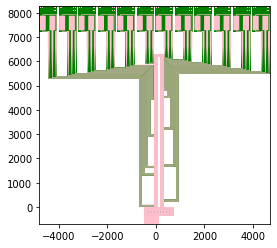

In [58]:
### build_interferometer.py
cell = Cell('MZI_active')

wg_width = 0.5
wafer_min_max = (0, 7200)

electrode_wg_sep = 62.5

inport_0 = Port((-electrode_wg_sep/2 - 25, 0), np.pi/2, wg_width)
inport_1 = Port((-electrode_wg_sep/2, 0), np.pi/2, wg_width)
inport_2 = Port((electrode_wg_sep/2, 0), np.pi/2, wg_width)
inport_3 = Port((electrode_wg_sep/2 + 25, 0), np.pi/2, wg_width)
device_inports = [inport_0, inport_1, inport_2, inport_3]
wgs_1 = [Waveguide.make_at_port(inport) for inport in device_inports]

wgs, _ = build_interferometer(
    cell=cell,
    wgs=wgs_1,
    electrode_length=1250,
    coupler_sep=0.4,
    coupler_length=30,
    sm_wg_width=wg_width,
    wg_layer=9,
    wf_layer=100,
    electrode_layer=10,
    electrode_wf_layer=102,
    electrode_contact_pad_coordinates=[],
    second_x_middle=2 * 127,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    mm_wg_width=1,
    mm_taper_length=30,
    electrode_wg_sep=electrode_wg_sep
)

# fiber_array
gc_pitch = 127
gc_leeway = 100
wg_sep = 25
min_radius = 50
starting_point = -gc_pitch * 2.5
ports = [wg.current_port for wg in wgs]
gc_y = (device_inports[0].origin[1]
        - min_radius
        - 3*wg_sep
        - gc_leeway)
grating_coupler_positions = [(starting_point+idx*gc_pitch, gc_y)
                             for idx in range(8)]


incoupling_bounds = wgs_to_fiber_array(
    cell=cell,
    ports=device_inports,
    coupler_positions=grating_coupler_positions[:4],
    min_radius=min_radius,
    gc_leeway=gc_leeway,
    wg_sep=wg_sep,
    wg_layer=9,
    wf_layer=100,
    is_incoupling=True
)

incoupling_wf_bounds = [incoupling_bounds[0]-15,
                        incoupling_bounds[3]-690,
                        incoupling_bounds[2]+gc_pitch/2-15,
                        incoupling_bounds[3]]

_ = wf_line_from_bounds(
            cell=cell,
            bounds=incoupling_wf_bounds,
            wf_maxlength=1040,
            wf_layer=100,
            axis=1
)

add_markers_to_bottom_of_cell(cell=cell,
                              wf_bounds=incoupling_wf_bounds,
                              device_bottom_bound=incoupling_bounds[1],
                              marker_dims=20,
                              marker_layer_1=3,
                              marker_layer_2=4,
                              marker_protection_layer=15)

outcoupling_bounds = wgs_to_fiber_array(
    cell=cell,
    ports=ports,
    coupler_positions=grating_coupler_positions[4:],
    min_radius=min_radius,
    gc_leeway=gc_leeway,
    wg_sep=wg_sep,
    wg_layer=9,
    wf_layer=100,
    is_incoupling=False
)

outcoupling_wf_bounds = [outcoupling_bounds[0]-gc_pitch/2+15,
                         outcoupling_bounds[1]-15,
                         outcoupling_bounds[2]+15,
                         outcoupling_bounds[3]]

_ = wf_line_from_bounds(
            cell=cell,
            bounds=outcoupling_wf_bounds,
            wf_maxlength=1040,
            wf_layer=100,
            axis=1
)

cell.save('../4x4_secondgen.gds')
cell.show()

In [ ]:
# # ### OLD CODE


# def fiber_array_to_coupling(
#     cell, ports, incoupling, wg_layer, wf_layer, coupler_separation,
#     min_radius, device_separation=500, leeways=(100, 100)
# ):
#     # Assume the first mode is the top mode
#     total_bounds = (np.inf, np.inf, -np.inf, -np.inf)
#     coupler_y_position = ports[0].origin[1] + min_radius + leeways[1]
#     wgs = [Waveguide.make_at_port(prt) for prt in ports]
#     for idx, wg in enumerate(wgs):
#         if incoupling:
#             wg._current_port.angle = wg.current_port.angle + np.pi
#         wg.add_straight_segment(device_separation + idx * coupler_separation - min_radius)
#         if incoupling:
#             wg.add_bend(-np.pi/2, min_radius)
#         else:
#             wg.add_bend(np.pi/2, min_radius)
#         wg.add_straight_segment(coupler_y_position - wg.current_port.origin[1])

#         total_bounds = update_bounds(total_bounds, wg.get_shapely_outline().bounds)
#         cell.add_to_layer(wg_layers[idx], wg)
        
#         grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
#             wg.current_port, **std_coupler_params
#         )

#         total_bounds = update_bounds(total_bounds,
#                                      grating_coupler.get_shapely_object().bounds)
#         cell.add_to_layer(wg_layers[idx], grating_coupler)
#     if incoupling:
#         # the first element is set to ensure the markers are far enough away from structures
#         leeway_for_bounds = [-leeways[0]-100, -leeways[1], 0, leeways[1]]
#     else:
#         leeway_for_bounds = [0, -leeways[1], leeways[0], leeways[1]]
#     total_bounds = np.add(total_bounds, leeway_for_bounds)
#     # single_wf_from_bounds(total_bounds, wf_layers)
#     wf_line_from_bounds(cell, total_bounds, 1040, wf_layer, axis=0)
#     return total_bounds


# initial_positions = (-25, 0)
# wgs_2, initial_positions_1 = build_section(
#     cell=cell,
#     section=1,
#     wgs=wgs_1,
#     initial_positions = initial_positions,
#     wafer_min_max=wafer_min_max,
#     electrode_length=1250,
#     coupler_sep=0.4,
#     coupler_length=30,
#     sm_wg_width=wg_width,
#     wg_layer=7,
#     wf_layer=107,
#     electrode_layer=15,
#     electrode_wf_layer=115,
#     electrode_sep=1.5,
#     total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
#     mm_wg_width = 1,
#     mm_taper_length = 30
# )

# wgs_3, initial_positions_2 = build_section(
#     cell=cell,
#     section=2,
#     wgs=wgs_2,
#     initial_positions = initial_positions_1,
#     wafer_min_max=wafer_min_max,
#     electrode_length=1250,
#     coupler_sep=0.4,
#     coupler_length=30,
#     sm_wg_width=wg_width,
#     wg_layer=7,
#     wf_layer=107,
#     electrode_layer=15,
#     electrode_wf_layer=115,
#     electrode_sep=1.5,
#     total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
#     mm_wg_width = 1,
#     mm_taper_length = 30
# )

# wgs_4, initial_positions_3 = build_section(
#     cell=cell,
#     section=1,
#     wgs=wgs_3,
#     initial_positions = initial_positions_2,
#     wafer_min_max=wafer_min_max,
#     electrode_length=1250,
#     coupler_sep=0.4,
#     coupler_length=30,
#     sm_wg_width=wg_width,
#     wg_layer=7,
#     wf_layer=107,
#     electrode_layer=15,
#     electrode_wf_layer=115,
#     electrode_sep=1.5,
#     total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
#     mm_wg_width = 1,
#     mm_taper_length = 30
# )

# wgs_out, initial_positions_4 = build_section(
#     cell=cell,
#     section=2,
#     wgs=wgs_4,
#     initial_positions = initial_positions_3,
#     wafer_min_max=wafer_min_max,
#     electrode_length=1250,
#     coupler_sep=0.4,
#     coupler_length=30,
#     sm_wg_width=wg_width,
#     wg_layer=7,
#     wf_layer=107,
#     electrode_layer=15,
#     electrode_wf_layer=115,
#     electrode_sep=1.5,
#     total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
#     last_layer = True,
#     mm_wg_width = 1,
#     mm_taper_length = 30
# )

# fiber_array_incouplers = [Waveguide.make_at_port(inport) for inport in device_inports]
# fiber_array_outcouplers = [Waveguide.make_at_port(wg.current_port) for wg in wgs_out]

# wg_sep = 25
# fiber_coupling_leeways = (100, 500)
# fiber_coupling_y_position = -450
# coupler_separation = 127.
# min_radius = 50

# for idx, wg in enumerate(fiber_array_incouplers):
#     wg._current_port.angle = wg.current_port.angle + np.pi
#     wg.add_bend(-np.pi/2, min_radius + wg_sep * idx)
#     wg.add_straight_segment(300)
#     wg.add_bend(np.pi/2, min_radius + wg_sep * (3-idx))
#     # y_segment
#     goal_y_position = fiber_coupling_y_position
#     current_y_position = wg.current_port.origin[1]
#     wg.add_straight_segment(current_y_position - goal_y_position - wg_sep*8)
#     wg.add_bend(np.pi/2, min_radius + wg_sep*(3-idx))
#     goal_x_position = ((device_inports[0].origin[0] + wgs_out[-1].current_port.origin[0])/2 
#                        - coupler_separation/2
#                        - (3-idx) * coupler_separation - min_radius)
#     current_x_position = wg.current_port.origin[0]
#     wg.add_straight_segment(abs(goal_x_position-current_x_position))
#     wg.add_bend(-np.pi/2, min_radius)
#     current_y_position = wg.current_port.origin[1]
#     wg.add_straight_segment(current_y_position-goal_y_position)
#     grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
#         wg.current_port, **std_coupler_params
#     )
#     cell.add_to_layer(7, wg, grating_coupler)
    
# for idx, wg in enumerate(fiber_array_outcouplers):
#     wg.add_bend(np.pi/2, min_radius + wg_sep * (3-idx))
#     wg.add_straight_segment(300)
#     wg.add_bend(-np.pi/2, min_radius + wg_sep * idx)
#     # y_segment
#     goal_y_position = fiber_coupling_y_position
#     current_y_position = wg.current_port.origin[1]
#     wg.add_straight_segment(current_y_position - goal_y_position - wg_sep*8)
#     wg.add_bend(-np.pi/2, min_radius + wg_sep*idx)
#     goal_x_position = ((device_inports[0].origin[0] + wgs_out[-1].current_port.origin[0])/2 
#                        + coupler_separation/2
#                        + (idx) * coupler_separation + min_radius)
#     current_x_position = wg.current_port.origin[0]
#     wg.add_straight_segment(current_x_position - goal_x_position)
#     wg.add_bend(np.pi/2, min_radius)
#     current_y_position = wg.current_port.origin[1]
#     wg.add_straight_segment(current_y_position-goal_y_position)
#     grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
#         wg.current_port, **std_coupler_params
#     )
#     cell.add_to_layer(7, wg, grating_coupler)

# def build_section(
#     cell,
#     section,
#     wgs,
#     initial_positions,
#     wafer_min_max,
#     electrode_length,
#     coupler_sep,
#     coupler_length,
#     sm_wg_width,
#     wg_layer,
#     wf_layer,
#     electrode_layer,
#     electrode_wf_layer,
#     total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
#     **kwargs
# ):
#     parameters = {
#         'mm_wg_width': sm_wg_width,
#         'mm_taper_length': 0,
#         'min_radius': 50,
#         'mzi_sep_leeway': 50,
#         'wg_sep': 25,
#         'electrode_wg_sep': 100,
#         'last_layer': False,
#         # For directional couplers and bends
#         'sine_s_x': 60,
#         # For electrode function
#         'electrode_width': 25,
#         'electrode_sep_y': 15,
#         'electrode_sep': 1.1,
#         'crossing_width': 10,
#         'electrode_taper_leeway': 5,
#         'electrode_taper_length': 30,
#         # For writefields
#         'wf_maxlength': 1040,
#         'wf_leeways': (10, 10),  # This should be strictly smaller than mzi_sep_leeways for the interferometer function
#         'wf_x_sep': 10,
#         'wf_electrode_leeways': (10, 10),
#         'wf_maxlength': 1040
#     }
    
#     fix_dict(parameters, kwargs)
    
#     if section==1:
#         global_x_middle, desired_x_position = expand_wgs_section_1(wgs, parameters)
#     elif section==2:
#         global_x_middle, desired_x_position = expand_wgs_section_2(wgs, parameters)
#     electrode_dc_bend_added_length = (electrode_length  # electrode
#                                       + coupler_length + 2*parameters['sine_s_x'] # directional coupler
#                                       + 2*parameters['mm_taper_length'] + parameters['sine_s_x'])  # directional coupler
#     if not parameters['last_layer']:
#         electrode_dc_bend_added_length += (max(1.5 * parameters['electrode_wg_sep'] - parameters['wg_sep'], 
#                                                parameters['min_radius']) 
#                                            + 3 * parameters['wg_sep'])
#     for electrode_idx in range(2):
#         # here we want a function for electrode+dc
#         if section==1:
#             section_1_dcs_electrodes(
#                 cell=cell,
#                 wgs=wgs,
#                 electrode_length=electrode_length,
#                 wg_layer=wg_layer,
#                 wf_layer=wf_layer,
#                 electrode_layer=electrode_layer,
#                 electrode_wf_layer=electrode_wf_layer,
#                 coupler_sep=coupler_sep,
#                 coupler_length=coupler_length,
#                 sm_wg_width=sm_wg_width,
#                 parameters=parameters
#             )
#         elif section==2:
#             section_2_dcs_electrodes(
#                 cell=cell,
#                 wgs=wgs,
#                 electrode_length=electrode_length,
#                 wg_layer=wg_layer,
#                 wf_layer=wf_layer,
#                 electrode_layer=electrode_layer,
#                 electrode_wf_layer=electrode_wf_layer,
#                 coupler_sep=coupler_sep,
#                 coupler_length=coupler_length,
#                 sm_wg_width=sm_wg_width,
#                 parameters=parameters
#             )
#         else:
#             print('There is no valid section 3, please change the \'section\' parameter to 1 or 2')
#         if (
#             (wgs[0].current_port.angle == np.pi/2 and 
#              wgs[0].current_port.origin[1] + electrode_dc_bend_added_length  > wafer_min_max[1])
#             and not (parameters['last_layer'] and electrode_idx==1) # don't want to add a bend for the last layer
#         ):
#             next_section = 2 - (section+electrode_idx)%2
#             wgs = build_curve(wgs=wgs,
#                               next_section=next_section,
#                               parameters=parameters)
            
# #             x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
# #                          global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
# #             wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], initial_positions[1],
# #                               x_extrema[1] + parameters['wf_leeways'][0], wgs[0].current_port.origin[1]+parameters['sine_s_x'])
# #             line_bounds = wf_line_from_bounds(bounds=wf_line_bounds,
# #                                 wf_maxlength=parameters['wf_maxlength'],
# #                                 wf_layer=wf_layer)
# #             #wf_bounds = update_bounds(total_bounds, line_bounds)
# #             deexpand_wgs(wgs, global_x_middle, parameters)
# #             wgs= wgs[::-1]
# #             for idx, wg in enumerate(wgs):
# #                 bend_radius = (max(1.5 * parameters['electrode_wg_sep'] - parameters['wg_sep'], 
# #                                    parameters['min_radius']) 
# #                                 + idx * parameters['wg_sep'])
# #                 wg.add_bend(-np.pi, bend_radius)
            
# #             initial_positions = wgs[0].current_port.origin
# #             wf_bend_bounds = (wf_line_bounds[0],
# #                               wf_line_bounds[3],
# #                               initial_positions[0] + 3 * parameters['wg_sep'] + parameters['wf_leeways'][0],
# #                               wf_line_bounds[3] + bend_radius + parameters['wf_leeways'][1])
# #             bend_bounds = wf_line_from_bounds(bounds=wf_bend_bounds,
# #                                               wf_maxlength=parameters['wf_maxlength'],
# #                                               wf_layer=wf_layer,
# #                                               axis=0)
# #             if electrode_idx == 0:
# #                 if section==1:
# #                     global_x_middle, desired_x_position = expand_wgs_section_1(wgs, parameters)
# #                 elif section==2:
# #                     global_x_middle, desired_x_position = expand_wgs_section_2(wgs, parameters)
                                      
#         elif (
#             (wgs[0].current_port.angle == -np.pi/2 and
#              wgs[0].current_port.origin[1] - electrode_dc_bend_added_length < wafer_min_max[0])
#             and not (parameters['last_layer'] and electrode_idx==1) # don't want to add a bend for the last layer
#         ):
#             x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
#                          global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
#             wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], wgs[0].current_port.origin[1]-parameters['sine_s_x'],
#                               x_extrema[1] + parameters['wf_leeways'][0], initial_positions[1])
#             line_bounds = wf_line_from_bounds(
#                                 cell=cell,
#                                 bounds=wf_line_bounds,
#                                 wf_maxlength=parameters['wf_maxlength'],
#                                 wf_layer=wf_layer)
#             #wf_bounds = update_bounds(total_bounds, line_bounds)
#             deexpand_wgs(wgs, global_x_middle, parameters)
#             wgs = wgs[::-1]
#             for idx, wg in enumerate(wgs):
#                 bend_radius = (max(1.5 * parameters['electrode_wg_sep'] - parameters['wg_sep'], 
#                                    parameters['min_radius'])
#                                + idx * parameters['wg_sep'])
#                 wg.add_bend(np.pi, bend_radius)
#             initial_positions = wgs[0].current_port.origin
#             wf_bend_bounds = (wf_line_bounds[0],
#                               wf_line_bounds[1] - bend_radius - parameters['wf_leeways'][1],
#                               initial_positions[0] + 3 * parameters['wg_sep'] + parameters['wf_leeways'][0],
#                               wf_line_bounds[1])
#             bend_bounds = wf_line_from_bounds(cell=cell,
#                                               bounds=wf_bend_bounds,
#                                               wf_maxlength=parameters['wf_maxlength'],
#                                               wf_layer=wf_layer,
#                                               axis=0)
#             if electrode_idx == 0:
#                 if section==1:
#                     global_x_middle, desired_x_position = expand_wgs_section_1(wgs, parameters)
#                 elif section==2:
#                     global_x_middle, desired_x_position = expand_wgs_section_2(wgs, parameters)
#         elif(parameters['last_layer'] and electrode_idx==1):
#             deexpand_wgs(wgs, global_x_middle, parameters)
#             if wgs[0].current_port.angle == np.pi/2:
#                 x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
#                              global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
#                 wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], 
#                                   initial_positions[1],
#                                   x_extrema[1] + parameters['wf_leeways'][0],
#                                   wgs[0].current_port.origin[1]+parameters['sine_s_x'])
#                 line_bounds = wf_line_from_bounds(
#                                     cell=cell,
#                                     bounds=wf_line_bounds,
#                                     wf_maxlength=parameters['wf_maxlength'],
#                                     wf_layer=wf_layer)
#             else:
#                 x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
#                              global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
#                 wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], wgs[0].current_port.origin[1],
#                                   x_extrema[1] + parameters['wf_leeways'][0], initial_positions[1])
#                 line_bounds = wf_line_from_bounds(cell=cell,
#                                                   bounds=wf_line_bounds,
#                                                   wf_maxlength=parameters['wf_maxlength'],
#                                                   wf_layer=wf_layer)

#     for wg in wgs:
#         cell.add_to_layer(wg_layer, wg)
# #     outports = [wg.current_port for wg in wgs]
#     return wgs, initial_positions
 